In [1]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from scipy import sparse
import warnings
import time
import sys
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth',100)
import h2o
from h2o.automl import H2OAutoML

In [2]:
train = pd.read_csv("./jinnan_round1_train_20181227.csv", encoding = 'gb18030')
test = pd.read_csv("./jinnan_round1_testA_20181227.csv", encoding = 'gb18030')

In [3]:
views = []
for col in train.columns:
    views.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
views_df = pd.DataFrame(views, columns=['Feature','value_count','null_percent','most_value_count','type'])
views_df.sort_values('null_percent', ascending=False)

,Feature,value_count,null_percent,most_value_count,type
2,A2,1,96,96.991404,float64
7,A7,75,89,89.326648,object
8,A8,8,89,89.326648,float64
39,B11,37,60,60.816619,object
38,B10,174,17,17.478510,object
3,A3,3,3,95.702006,float64
0,sample_id,1396,0,0.071633,object
33,B5,60,0,17.550143,object
26,A26,87,0,19.054441,object
27,A27,13,0,45.128940,int64


In [4]:
views = []
for col in test.columns:
    views.append((col, test[col].nunique(), test[col].isnull().sum() * 100 / test.shape[0], test[col].value_counts(normalize=True, dropna=False).values[0] * 100, test[col].dtype))
views_df = pd.DataFrame(views, columns=['Feature','value_count','null_percent','most_value_count','type'])
views_df.sort_values('null_percent', ascending=False)

,Feature,value_count,null_percent,most_value_count,type
2,A2,1,98,98.000000,float64
7,A7,15,88,88.000000,object
8,A8,2,88,88.000000,float64
39,B11,11,59,59.333333,object
38,B10,50,14,14.666667,object
3,A3,2,2,97.333333,float64
0,sample_id,150,0,0.666667,object
32,B4,51,0,20.666667,object
26,A26,41,0,21.333333,object
27,A27,11,0,47.333333,int64


In [5]:
# 删除某一类别占比超过90%的列
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
        print(col,rate)

good_cols.append('A1')
good_cols.append('A3')
good_cols.append('A4')
# 删除异常值
train = train[(train['score'] > 0.87) & (train['B14'] > 40) & (train['A6'] < 50)]

train = train[good_cols]
good_cols.remove('score')
test  = test[good_cols]

(u'A1', 0.9863896848137536)
(u'A2', 0.9699140401146131)
(u'A3', 0.9570200573065902)
(u'A4', 0.9570200573065902)
(u'A13', 0.998567335243553)
(u'A18', 0.9992836676217765)
(u'A21', 0.9004297994269341)
(u'A23', 0.997134670487106)
(u'B2', 0.9856733524355301)
(u'B3', 0.9992836676217765)
(u'B13', 0.994269340974212)


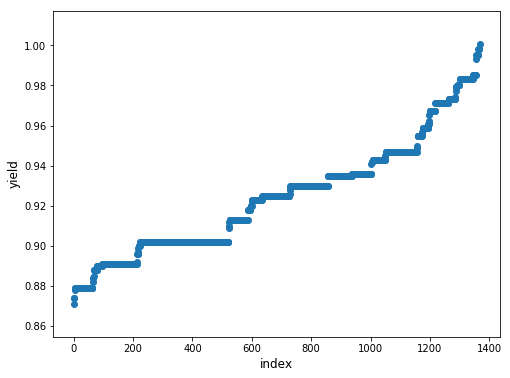

In [6]:
target_col = 'score'
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

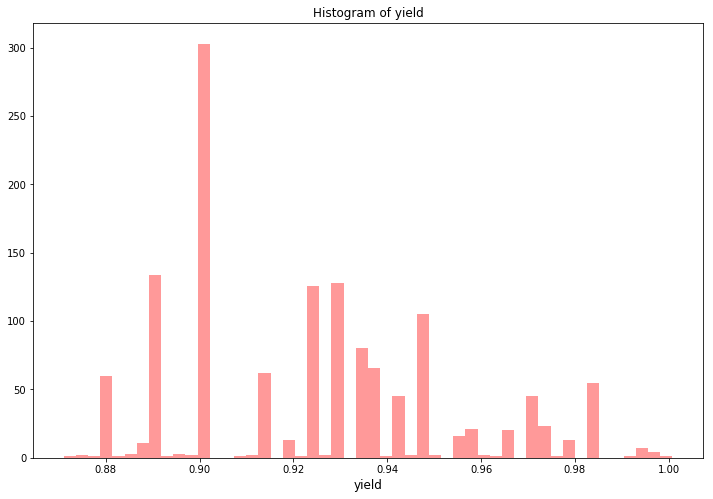

In [7]:
plt.figure(figsize=(12,8))
sns.distplot(train[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of yield")
plt.xlabel('yield', fontsize=12)
plt.show()

In [8]:
train = train[train[target_col]>0.87]

In [9]:
def TimeToInt(t, previous = 0):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return (23*3600)/3600
        elif t=='1900/1/1 2:30':
            return (21*3600+30*60)/3600
        elif t=='1/21/1900 0:00':
            return (21*3600+30*60)/3600
        elif t=='1900/1/22 0:00':
            return (22*3600)/3600
        elif t=='1/12/1900 0:00':
            return (12*3600)/3600
        elif t==-1:
            return -1
        else:
            return 0
    
    try:
        tm = (int(t)*3600+int(m)*60+int(s))/3600
        if tm < previous:
            tm += 24
    except:
        return (30*60)/3600
    
    return tm

def TimeToDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1
    try:
        duration = (int(eh)*60+int(em)-int(sm)-int(sh)*60)/60
        if duration < 0:
            duration += 24
        return duration
    except:
        return 0

def Between(t1, t2):
    if t1 < 0 or t2 < 0:
        return -1
    duration = 0
    try:
        duration = t1 - t2
        if duration < 0:
            duration += 24
    except:
        duration = 0
    return duration

def getBeforeTime(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1       
    try:
        tm = (int(sh)*3600+int(sm)*60)/3600
    except:
        if se=='19:-20:05':
            return (19*3600+5*60)/3600
        elif se=='15:00-1600':
            return 15*3600/3600       
    return tm

def adjust(t1, t2):
    if t1 < 0 or t2 < 0:
        return -1
    if t1 < t2:
        return t1 + 24
    return t1

def getAfterTime(t1, t2):
    if t1 < 0 or t2 < 0:
        return -1
    return t1 + t2

In [10]:
target = train['score']
del train['score']
data = pd.concat([train,test],axis=0,ignore_index=True)
data = data.fillna(-1)
#del data['sample_id']

In [11]:
for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
    data[f] = data[f].apply(TimeToInt)

In [12]:
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f+'_duration'] = data.apply(lambda data: TimeToDuration(data[f]), axis=1)

for f in ['A20','A28','B4','B9','B10','B11']:
    data[f+'_before_time'] = data.apply(lambda data: getBeforeTime(data[f]), axis=1)
    
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f+'_after_time'] = data.apply(lambda data: getAfterTime(data[f+'_before_time'], data[f+'_duration']), axis=1)

In [13]:
for f in [['A7', 'A5'],['A9', 'A5'],['A11', 'A9'],['A14', 'A11'],['A16', 'A14'],['A24', 'A16'],['A26', 'A24'],['B5', 'A26'],['B7', 'B5']]:
    data[f[0]] = data.apply(lambda data: adjust(data[f[0]], data[f[1]]), axis=1)

for f in [['A20_before_time','A16'],['A28_before_time', 'A26'],['B4_before_time','A28_before_time'],['B9_before_time', 'A5'],['B10_before_time','A5'],['B11_before_time','A5']]:
    data[f[0]] = data.apply(lambda data: adjust(data[f[0]], data[f[1]]), axis=1)
    
for f in [['A20_after_time','A20_before_time'],['A28_after_time', 'A28_before_time'],['B4_after_time','B4_before_time'],['B9_after_time', 'B9_before_time'],['B10_after_time','B10_before_time'],['B11_after_time','B11_before_time']]:
    data[f[0]] = data.apply(lambda data: adjust(data[f[0]], data[f[1]]), axis=1)

In [14]:
for f in [['A20_before_time','A5'],['A28_before_time', 'A5'],['B4_before_time','A5'],['B9_before_time', 'A5'],['B10_before_time','A5'],['B11_before_time','A5']]:
    data[f[0]] = data.apply(lambda data: Between(data[f[0]], data[f[1]]), axis=1)
for f in [['A20_after_time','A5'],['A28_after_time', 'A5'],['B4_after_time','A5'],['B9_after_time', 'A5'],['B10_after_time','A5'],['B11_after_time','A5']]:
    data[f[0]] = data.apply(lambda data: Between(data[f[0]], data[f[1]]), axis=1)
for f in [['A7', 'A5'],['A9', 'A5'],['A11', 'A5'],['A14', 'A5'],['A16', 'A5'],['A24', 'A5'],['A26', 'A5'],['B5', 'A5'],['B7', 'A5']]:
    data[f[0]] = data.apply(lambda data: Between(data[f[0]], data[f[1]]), axis=1)
for f in [['A7', 'A5'],['A9', 'A5'],['A11', 'A9'],['A14', 'A11'],['A16', 'A14'],['A24', 'A16'],['A26', 'A24'],['B5', 'A26'],['B7', 'B5']]:
    data[f[0]+'duration'] = data.apply(lambda data: Between(data[f[0]], data[f[1]]), axis=1)
for f in ['A20','A28','B4','B9','B10','B11']:
    del data[f]

In [15]:
categorical_columns = [f for f in data.columns if f not in ['sample_id']]
for f in categorical_columns:
    cate_rate = data[f].value_counts(normalize=True, dropna=False).values[0]
    if cate_rate < 0.90:
        data[f+'_median'] = data[f].median()
        data[f+'_std'] = data[f].std()
        data[f+'_max'] = data[f].max()
        data[f+'_min'] = data[f].min()
        data[f+'_**2'] = data[f].min()**2
        data[f+'_**1/2'] = data[f].min()**(1/2)
    
print(data.shape)

"\ncategorical_columns = [f for f in data.columns if f not in ['sample_id']]\nfor f in categorical_columns:\n    cate_rate = data[f].value_counts(normalize=True, dropna=False).values[0]\n    if cate_rate < 0.90:\n        data[f+'_median'] = data[f].median()\n        data[f+'_std'] = data[f].std()\n        data[f+'_max'] = data[f].max()\n        data[f+'_min'] = data[f].min()\n        data[f+'_**2'] = data[f].min()**2\n        data[f+'_**1/2'] = data[f].min()**(1/2)\n    \nprint(data.shape)\n"

In [16]:
def merge_median(data,columns,value,cname):
    add = pd.DataFrame(data.groupby(columns)[value].median()).reset_index()
    add.columns=columns+[cname]
    data=data.merge(add,on=columns,how="left")
    return data

def merge_mean(data,columns,value,cname):
    add = pd.DataFrame(data.groupby(columns)[value].mean()).reset_index()
    add.columns=columns+[cname]
    data=data.merge(add,on=columns,how="left")
    return data

def merge_max(data,columns,value,cname):
    add = pd.DataFrame(data.groupby(columns)[value].max()).reset_index()
    add.columns=columns+[cname]
    data=data.merge(add,on=columns,how="left")
    return data

def merge_min(data,columns,value,cname):
    add = pd.DataFrame(data.groupby(columns)[value].min()).reset_index()
    add.columns=columns+[cname]
    data=data.merge(add,on=columns,how="left")
    return data

def merge_std(data,columns,value,cname):
    add = pd.DataFrame(data.groupby(columns)[value].std()).reset_index()
    add.columns=columns+[cname]
    data=data.merge(add,on=columns,how="left")
    return data

def merge_div(t1, t2):
    if t2 == 0:
        return 0
    return t1 / t2

In [17]:
data = merge_median(data, ['A8'], 'A7', 'A8_A7_median')
data = merge_median(data, ['A10'], 'A9', 'A10_A9_median')
data = merge_median(data, ['A12'], 'A11', 'A12_A11_median')
data = merge_median(data, ['A15'], 'A14', 'A15_A14_median')
data = merge_median(data, ['A17'], 'A16', 'A17_A16_median')
data = merge_median(data, ['A25'], 'A24', 'A25_A24_median')
data = merge_median(data, ['A27'], 'A26', 'A27_A26_median')
data = merge_median(data, ['B6'], 'B5', 'B6_B5_median')
data = merge_median(data, ['B8'], 'B7', 'B8_B7_median')

data = merge_mean(data, ['A8'], 'A7', 'A8_A7_mean')
data = merge_mean(data, ['A10'], 'A9', 'A10_A9_mean')
data = merge_mean(data, ['A12'], 'A11', 'A12_A11_mean')
data = merge_mean(data, ['A15'], 'A14', 'A15_A14_mean')
data = merge_mean(data, ['A17'], 'A16', 'A17_A16_mean')
data = merge_mean(data, ['A25'], 'A24', 'A25_A24_mean')
data = merge_mean(data, ['A27'], 'A26', 'A27_A26_mean')
data = merge_mean(data, ['B6'], 'B5', 'B6_B5_mean')
data = merge_mean(data, ['B8'], 'B7', 'B8_B7_mean')

data = merge_max(data, ['A8'], 'A7', 'A8_A7_max')
data = merge_max(data, ['A10'], 'A9', 'A10_A9_max')
data = merge_max(data, ['A12'], 'A11', 'A12_A11_max')
data = merge_max(data, ['A15'], 'A14', 'A15_A14_max')
data = merge_max(data, ['A17'], 'A16', 'A17_A16_max')
data = merge_max(data, ['A25'], 'A24', 'A25_A24_max')
data = merge_max(data, ['A27'], 'A26', 'A27_A26_max')
data = merge_max(data, ['B6'], 'B5', 'B6_B5_max')
data = merge_max(data, ['B8'], 'B7', 'B8_B7_max')

data = merge_min(data, ['A8'], 'A7', 'A8_A7_min')
data = merge_min(data, ['A10'], 'A9', 'A10_A9_min')
data = merge_min(data, ['A12'], 'A11', 'A12_A11_min')
data = merge_min(data, ['A15'], 'A14', 'A15_A14_min')
data = merge_min(data, ['A17'], 'A16', 'A17_A16_min')
data = merge_min(data, ['A25'], 'A24', 'A25_A24_min')
data = merge_min(data, ['A27'], 'A26', 'A27_A26_min')
data = merge_min(data, ['B6'], 'B5', 'B6_B5_min')
data = merge_min(data, ['B8'], 'B7', 'B8_B7_min')

data = merge_std(data, ['A8'], 'A7', 'A8_A7_std')
data = merge_std(data, ['A10'], 'A9', 'A10_A9_std')
data = merge_std(data, ['A12'], 'A11', 'A12_A11_std')
data = merge_std(data, ['A15'], 'A14', 'A15_A14_std')
data = merge_std(data, ['A17'], 'A16', 'A17_A16_std')
data = merge_std(data, ['A25'], 'A24', 'A25_A24_std')
data = merge_std(data, ['A27'], 'A26', 'A27_A26_std')
data = merge_std(data, ['B6'], 'B5', 'B6_B5_std')
data = merge_std(data, ['B8'], 'B7', 'B8_B7_std')

data['A8_A7_div'] = data.apply(lambda df: merge_div(df['A8'], df['A7']), axis=1)
data['A10_A9_div'] = data.apply(lambda df: merge_div(df['A10'], df['A9']), axis=1)
data['A12_A11_div'] = data.apply(lambda df: merge_div(df['A12'], df['A11']), axis=1)
data['A15_A14_div'] = data.apply(lambda df: merge_div(df['A15'], df['A14']), axis=1)
data['A17_A16_div'] = data.apply(lambda df: merge_div(df['A17'], df['A16']), axis=1)
data['A25_A24_div'] = data.apply(lambda df: merge_div(df['A25'], df['A24']), axis=1)
data['A27_A26_div'] = data.apply(lambda df: merge_div(df['A27'], df['A26']), axis=1)
data['B6_B5_div'] = data.apply(lambda df: merge_div(df['B6'], df['B5']), axis=1)
data['B8_B7_div'] = data.apply(lambda df: merge_div(df['B8'], df['B7']), axis=1)

"\ndata = merge_median(data, ['A8'], 'A7', 'A8_A7_median')\ndata = merge_median(data, ['A10'], 'A9', 'A10_A9_median')\ndata = merge_median(data, ['A12'], 'A11', 'A12_A11_median')\ndata = merge_median(data, ['A15'], 'A14', 'A15_A14_median')\ndata = merge_median(data, ['A17'], 'A16', 'A17_A16_median')\ndata = merge_median(data, ['A25'], 'A24', 'A25_A24_median')\ndata = merge_median(data, ['A27'], 'A26', 'A27_A26_median')\ndata = merge_median(data, ['B6'], 'B5', 'B6_B5_median')\ndata = merge_median(data, ['B8'], 'B7', 'B8_B7_median')\n\ndata = merge_mean(data, ['A8'], 'A7', 'A8_A7_mean')\ndata = merge_mean(data, ['A10'], 'A9', 'A10_A9_mean')\ndata = merge_mean(data, ['A12'], 'A11', 'A12_A11_mean')\ndata = merge_mean(data, ['A15'], 'A14', 'A15_A14_mean')\ndata = merge_mean(data, ['A17'], 'A16', 'A17_A16_mean')\ndata = merge_mean(data, ['A25'], 'A24', 'A25_A24_mean')\ndata = merge_mean(data, ['A27'], 'A26', 'A27_A26_mean')\ndata = merge_mean(data, ['B6'], 'B5', 'B6_B5_mean')\ndata = merge_m

In [18]:
data.head()

,sample_id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A22,A24,A25,A26,A27,B1,B5,B6,B7,B8,B12,B14,A1,A3,A4,A20_duration,A28_duration,B4_duration,B9_duration,B10_duration,B11_duration,A20_before_time,A28_before_time,B4_before_time,B9_before_time,B10_before_time,B11_before_time,A20_after_time,A28_after_time,B4_after_time,B9_after_time,B10_after_time,B11_after_time,A7duration,A9duration,A11duration,A14duration,A16duration,A24duration,A26duration,B5duration,B7duration
0,sample_1528,13,38.0,-1,-1.0,2,100,3,102.0,4,103.0,5,104.0,300,9,9,75,9,70,350,19,65,22,45,800,400,300,405.0,700,0,0,1,1,1,-1,8,17,18,22,1,-1,8,17,19,23,2,-1,-1,13,1,1,1,4,0,10,3
1,sample_1698,14,29.0,-1,-1.0,2,101,3,103.0,4,104.0,5,105.0,200,9,6,80,7,73,320,9,80,16,45,1200,400,300,405.0,700,1,1,1,1,1,1,5,7,8,16,17,19,6,8,9,17,18,20,-1,12,1,1,1,1,1,2,7
2,sample_639,14,29.0,-1,-1.0,2,102,3,103.0,4,104.0,5,105.0,200,9,6,79,7,73,320,9,80,11,45,1200,400,300,405.0,700,0,1,1,1,1,1,5,7,8,11,12,14,5,8,9,12,13,15,-1,12,1,1,1,1,1,2,2
3,sample_483,1,38.0,-1,-1.0,2,100,3,102.0,4,103.0,5,104.0,200,10,6,70,7,78,290,14,65,17,45,800,400,300,405.0,700,0,1,1,1,1,-1,5,12,13,18,20,-1,5,13,14,19,21,-1,-1,1,1,1,1,1,1,7,3
4,sample_617,22,29.0,-1,-1.0,2,101,3,103.0,4,104.0,5,105.0,200,9,6,80,7,73,320,9,80,11,45,1200,420,300,405.0,700,1,1,1,1,1,1,5,7,8,11,12,14,6,8,9,12,13,15,-1,4,1,1,1,1,1,2,2


In [19]:
data['sample_id'] = data['sample_id'].apply(lambda x: int(x.split('_')[1]))

categorical_columns = [f for f in data.columns if f not in ['sample_id']]
numerical_columns = [f for f in data.columns if f not in categorical_columns]

In [20]:
categorical_columns = [f for f in data.columns]

for f in ['B14']:
    data[f+'_median'] = data[f].median()
    data[f+'_std'] = data[f].std()
    data[f+'_max'] = data[f].max()
    data[f+'_min'] = data[f].min()
    data[f+'**2'] = data[f]**2

In [21]:
data['b14/a1_a3_a4_a19_b1_b12'] = data['B14']/(data['A1']+data['A3']+data['A4']+data['A19']+data['B1']+data['B12'])

numerical_columns.append('b14/a1_a3_a4_a19_b1_b12')

del data['A1']
del data['A3']
del data['A4']
categorical_columns.remove('A1')
categorical_columns.remove('A3')
categorical_columns.remove('A4')

In [22]:
#label encoder
for f in categorical_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train.shape[0]]
test  = data[train.shape[0]:]
print(train.shape)
print(test.shape)

(1368, 59)
(150, 59)


In [23]:
#train['target'] = list(target) 
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
mean_columns = []
for f1 in categorical_columns:
    cate_rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
    if cate_rate < 0.90:
        for f2 in li:
            col_name = 'B14_to_'+f1+"_"+f2+'_mean'
            mean_columns.append(col_name)
            order_label = train.groupby([f1])[f2].mean()
            train[col_name] = train['B14'].map(order_label)
            miss_rate = train[col_name].isnull().sum() * 100 / train[col_name].shape[0]
            if miss_rate > 0:
                train = train.drop([col_name], axis=1)
                mean_columns.remove(col_name)
            else:
                test[col_name] = test['B14'].map(order_label)
                
train.drop(li+['target'], axis=1, inplace=True)
print(train.shape)
print(test.shape)

(1368, 229)
(150, 229)


In [ ]:
def modeling_cross_validation(params, X, y, nr_folds=5):
    
    oof_preds = np.zeros(X.shape[0])
    # Split data with kfold
    folds = KFold(n_splits=nr_folds, shuffle=False, random_state=4096)
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print("fold n°{}".format(fold_+1))
        trn_data = lgb.Dataset(X[trn_idx], y[trn_idx])
        val_data = lgb.Dataset(X[val_idx], y[val_idx])

        num_round = 20000
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
        oof_preds[val_idx] = clf.predict(X[val_idx], num_iteration=clf.best_iteration)

    score = mean_squared_error(oof_preds, target)
    
    return  score/2

In [ ]:
def featureSelect(init_cols):
    params = {'num_leaves': 120,
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.05,
             "min_child_samples": 30,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'mse',
             "lambda_l1": 0.02,
             "verbosity": -1}
    best_cols = list(init_cols)
    best_score = modeling_cross_validation(params, train[init_cols].values, target.values, nr_folds=5)
    print("初始CV score: {:<8.8f}".format(best_score))
    for f in init_cols:

        best_cols.remove(f)
        score = modeling_cross_validation(params, train[best_cols].values, target.values, nr_folds=5)
        diff = best_score - score
        print('-'*10)
        if diff > 0.0000002:
            print("当前移除特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 有效果,删除！！".format(f,score,best_score))
            best_score = score
        else:
            print("当前移除特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 没效果,保留！！".format(f,score,best_score))
            best_cols.append(f)
    print('-'*10)
    print("优化后CV score: {:<8.8f}".format(best_score))
    
    return best_cols
    
best_features = featureSelect(train.columns.tolist())

In [24]:
X_train = train[mean_columns+numerical_columns].values
X_test = test[mean_columns+numerical_columns].values
# one hot
enc = OneHotEncoder()
for f in categorical_columns:
    enc.fit(data[f].values.reshape(-1, 1))
    X_train = sparse.hstack((X_train, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
    X_test = sparse.hstack((X_test, enc.transform(test[f].values.reshape(-1, 1))), 'csr')
print(X_train.shape)
print(X_test.shape)

y_train = target.values

(1368, 2513)
(150, 2513)


In [25]:
train.head()

,sample_id,A5,A6,A7,A8,A9,A10,A11,A12,A14,A15,A16,A17,A19,A22,A24,A25,A26,A27,B1,B5,B6,B7,B8,B12,B14,A20_duration,A28_duration,B4_duration,B9_duration,B10_duration,B11_duration,A20_before_time,A28_before_time,B4_before_time,B9_before_time,B10_before_time,B11_before_time,A20_after_time,A28_after_time,B4_after_time,B9_after_time,B10_after_time,B11_after_time,A7duration,A9duration,A11duration,A14duration,A16duration,A24duration,A26duration,B5duration,B7duration,B14_median,B14_std,B14_max,B14_min,B14**2,b14/a1_a3_a4_a19_b1_b12,B14_to_sample_id_intTarget_0.0_mean,B14_to_sample_id_intTarget_1.0_mean,B14_to_sample_id_intTarget_2.0_mean,B14_to_sample_id_intTarget_3.0_mean,B14_to_sample_id_intTarget_4.0_mean,B14_to_A5_intTarget_0.0_mean,B14_to_A5_intTarget_1.0_mean,B14_to_A5_intTarget_2.0_mean,B14_to_A5_intTarget_3.0_mean,B14_to_A5_intTarget_4.0_mean,B14_to_A6_intTarget_0.0_mean,B14_to_A6_intTarget_1.0_mean,B14_to_A6_intTarget_2.0_mean,B14_to_A6_intTarget_3.0_mean,B14_to_A6_intTarget_4.0_mean,B14_to_A11_intTarget_0.0_mean,B14_to_A11_intTarget_1.0_mean,B14_to_A11_intTarget_2.0_mean,B14_to_A11_intTarget_3.0_mean,B14_to_A11_intTarget_4.0_mean,B14_to_A14_intTarget_0.0_mean,B14_to_A14_intTarget_1.0_mean,B14_to_A14_intTarget_2.0_mean,B14_to_A14_intTarget_3.0_mean,B14_to_A14_intTarget_4.0_mean,B14_to_A16_intTarget_0.0_mean,B14_to_A16_intTarget_1.0_mean,B14_to_A16_intTarget_2.0_mean,B14_to_A16_intTarget_3.0_mean,B14_to_A16_intTarget_4.0_mean,B14_to_A17_intTarget_0.0_mean,B14_to_A17_intTarget_1.0_mean,B14_to_A17_intTarget_2.0_mean,B14_to_A17_intTarget_3.0_mean,B14_to_A17_intTarget_4.0_mean,B14_to_A24_intTarget_0.0_mean,B14_to_A24_intTarget_1.0_mean,B14_to_A24_intTarget_2.0_mean,B14_to_A24_intTarget_3.0_mean,B14_to_A24_intTarget_4.0_mean,B14_to_A25_intTarget_0.0_mean,B14_to_A25_intTarget_1.0_mean,B14_to_A25_intTarget_2.0_mean,B14_to_A25_intTarget_3.0_mean,B14_to_A25_intTarget_4.0_mean,B14_to_A26_intTarget_0.0_mean,B14_to_A26_intTarget_1.0_mean,B14_to_A26_intTarget_2.0_mean,B14_to_A26_intTarget_3.0_mean,B14_to_A26_intTarget_4.0_mean,B14_to_A27_intTarget_0.0_mean,B14_to_A27_intTarget_1.0_mean,B14_to_A27_intTarget_2.0_mean,B14_to_A27_intTarget_3.0_mean,B14_to_A27_intTarget_4.0_mean,B14_to_B1_intTarget_0.0_mean,B14_to_B1_intTarget_1.0_mean,B14_to_B1_intTarget_2.0_mean,B14_to_B1_intTarget_3.0_mean,B14_to_B1_intTarget_4.0_mean,B14_to_B5_intTarget_0.0_mean,B14_to_B5_intTarget_1.0_mean,B14_to_B5_intTarget_2.0_mean,B14_to_B5_intTarget_3.0_mean,B14_to_B5_intTarget_4.0_mean,B14_to_B6_intTarget_0.0_mean,B14_to_B6_intTarget_1.0_mean,B14_to_B6_intTarget_2.0_mean,B14_to_B6_intTarget_3.0_mean,B14_to_B6_intTarget_4.0_mean,B14_to_B7_intTarget_0.0_mean,B14_to_B7_intTarget_1.0_mean,B14_to_B7_intTarget_2.0_mean,B14_to_B7_intTarget_3.0_mean,B14_to_B7_intTarget_4.0_mean,B14_to_B8_intTarget_0.0_mean,B14_to_B8_intTarget_1.0_mean,B14_to_B8_intTarget_2.0_mean,B14_to_B8_intTarget_3.0_mean,B14_to_B8_intTarget_4.0_mean,B14_to_B14_intTarget_0.0_mean,B14_to_B14_intTarget_1.0_mean,B14_to_B14_intTarget_2.0_mean,B14_to_B14_intTarget_3.0_mean,B14_to_B14_intTarget_4.0_mean,B14_to_A20_before_time_intTarget_0.0_mean,B14_to_A20_before_time_intTarget_1.0_mean,B14_to_A20_before_time_intTarget_2.0_mean,B14_to_A20_before_time_intTarget_3.0_mean,B14_to_A20_before_time_intTarget_4.0_mean,B14_to_A28_before_time_intTarget_0.0_mean,B14_to_A28_before_time_intTarget_1.0_mean,B14_to_A28_before_time_intTarget_2.0_mean,B14_to_A28_before_time_intTarget_3.0_mean,B14_to_A28_before_time_intTarget_4.0_mean,B14_to_B4_before_time_intTarget_0.0_mean,B14_to_B4_before_time_intTarget_1.0_mean,B14_to_B4_before_time_intTarget_2.0_mean,B14_to_B4_before_time_intTarget_3.0_mean,B14_to_B4_before_time_intTarget_4.0_mean,B14_to_B9_before_time_intTarget_0.0_mean,B14_to_B9_before_time_intTarget_1.0_mean,B14_to_B9_before_time_intTarget_2.0_mean,B14_to_B9_before_time_intTarget_3.0_mean,B14_to_B9_before_time_intTarget_4.0_mean,B14_to_B10_before_time_intTarget_0.0_mean,B14_to_B10_before_time_intTarget_1.0_mean,B14_to_B10_b

In [26]:
y_train=target.values

In [27]:
def lgbFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)*0.5
    return 'lgbFeval',score,False

param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    clf = lgb.train(param, 
                    trn_data, 
                    num_boost_round=10000, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval = 200, 
                    feval = lgbFeval,
                    early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits
    '''
    feature_imp = pd.DataFrame(sorted(
        zip(clf.feature_importance(importance_type='split'), clf.feature_importance(importance_type='gain'), categorical_columns)),
                               columns=['split', 'gain', 'Feature'])
    feature_imp.sort_values(by=['split'], inplace=True, ascending=False)
    print(feature_imp)
    '''

print("LGB score: {}".format((mean_squared_error(oof_lgb, target)*0.5)))

sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions_lgb
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("zw_lgb_submission.csv", index=False, header=None)

fold n°1
Training until validation scores don't improve for 200 rounds.
[200]	training's l2: 0.000224714	training's lgbFeval: 0.000112357	valid_1's l2: 0.000240621	valid_1's lgbFeval: 0.00012031
[400]	training's l2: 0.000178202	training's lgbFeval: 8.9101e-05	valid_1's l2: 0.000191963	valid_1's lgbFeval: 9.59817e-05
[600]	training's l2: 0.000160101	training's lgbFeval: 8.00507e-05	valid_1's l2: 0.000181401	valid_1's lgbFeval: 9.07006e-05
[800]	training's l2: 0.000150054	training's lgbFeval: 7.50269e-05	valid_1's l2: 0.00017775	valid_1's lgbFeval: 8.88751e-05
[1000]	training's l2: 0.000143013	training's lgbFeval: 7.15063e-05	valid_1's l2: 0.000175509	valid_1's lgbFeval: 8.77544e-05
[1200]	training's l2: 0.000137733	training's lgbFeval: 6.88665e-05	valid_1's l2: 0.000174172	valid_1's lgbFeval: 8.70861e-05
[1400]	training's l2: 0.000133781	training's lgbFeval: 6.68904e-05	valid_1's l2: 0.000173669	valid_1's lgbFeval: 8.68346e-05
[1600]	training's l2: 0.000130443	training's lgbFeval: 6.522

In [28]:
def xgbFeval(preds, xgbtrain):
    label = xgbtrain.get_label()
    score = mean_squared_error(label,preds)*0.5
    return 'xgbFeval',score
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, feval = xgbFeval, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=200, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits

print("XGB score: {}".format((mean_squared_error(oof_xgb, target)*0.5)))
sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions_xgb
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("zw_xgb_submission.csv", index=False, header=None)

fold n°1
[0]	train-rmse:0.422766	valid_data-rmse:0.425891	train-xgbFeval:0.089366	valid_data-xgbFeval:0.090691
Multiple eval metrics have been passed: 'valid_data-xgbFeval' will be used for early stopping.

Will train until valid_data-xgbFeval hasn't improved in 200 rounds.
[200]	train-rmse:0.156544	valid_data-rmse:0.158857	train-xgbFeval:0.012253	valid_data-xgbFeval:0.012618
[400]	train-rmse:0.059324	valid_data-rmse:0.061168	train-xgbFeval:0.00176	valid_data-xgbFeval:0.001871
[600]	train-rmse:0.024399	valid_data-rmse:0.026247	train-xgbFeval:0.000298	valid_data-xgbFeval:0.000344
[800]	train-rmse:0.012568	valid_data-rmse:0.015595	train-xgbFeval:7.9e-05	valid_data-xgbFeval:0.000122
[1000]	train-rmse:0.009039	valid_data-rmse:0.01332	train-xgbFeval:4.1e-05	valid_data-xgbFeval:8.9e-05
[1200]	train-rmse:0.007809	valid_data-rmse:0.012956	train-xgbFeval:3e-05	valid_data-xgbFeval:8.4e-05
[1400]	train-rmse:0.00707	valid_data-rmse:0.012923	train-xgbFeval:2.5e-05	valid_data-xgbFeval:8.4e-05
Stoppi

KeyboardInterrupt: 

In [ ]:
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack_xgb = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = xgb.XGBRegressor()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack_xgb[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("STACK score: {}".format((mean_squared_error(target.values, oof_stack_xgb)*0.5)))

sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("xgbstack_submission"+ format((mean_squared_error(target.values, oof_stack_xgb)*0.5)) +".csv", index=False, header=None)


In [ ]:
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack_cbt = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = ctb.CatBoostRegressor()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack_cbt[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("STACK score: {}".format((mean_squared_error(target.values, oof_stack_cbt)*0.5)))

sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))
sub_df.to_csv("cbtstack_submission"+ format((mean_squared_error(target.values, oof_stack_cbt)*0.5)) +".csv", index=False, header=None)


In [ ]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack_bys = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack_bys[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
print("STACK score: {}".format((mean_squared_error(target.values, oof_stack_bys)*0.5)))
sub_df = pd.read_csv('submission.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1]
sub_df.to_csv("bysstack_submission"+ format((mean_squared_error(target.values, oof_stack_bys)*0.5)) +".csv", index=False, header=None)

In [ ]:
print("LY LGB score: {}".format((mean_squared_error(oof_lgb, target)*0.5)))
print("LY XGB score: {}".format((mean_squared_error(oof_xgb, target)*0.5)))
print("CBT STACK score: {}".format((mean_squared_error(target.values, oof_stack_cbt)*0.5)))
print("XGB STACK score: {}".format((mean_squared_error(target.values, oof_stack_xgb)*0.5)))
print("BYS STACK score: {}".format((mean_squared_error(target.values, oof_stack_bys)*0.5)))